In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. imag height = 1080 , width = 1920  
2. total : 200 images  
3. json annotation -> Six standard classes are used which are:  
  **Undrivable(areas where one cannot ride to), Road, Lanemark, My bike, Rider, Movable(vehicles, people etc)**

# import libraries

In [2]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# Data Exploration

In [4]:
dataDir = '/content/drive/MyDrive/MotorcycleNight_dataset'
annFile = '/content/drive/MyDrive/MotorcycleNight_dataset/COCO_motorcycle.json'

# coco api를 사용하여 COCO class 객체 생성
coco=COCO(annFile)

loading annotations into memory...
Done (t=5.24s)
creating index...
index created!


In [13]:
# COCO categories 확인
#Category 이름, Super Category 이름을 input으로, 그에 해당하는 Category  id를 return하는 함수.
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))

6 COCO categories: 
Rider My bike Moveable Lane Mark Road Undrivable

6 COCO supercategories: 
Road Undrivable Moveable Rider My bike Lane Mark


ㄴ> supercategory 와 category의 집합은 같다.

In [7]:
# 카테고리에 속한 id파악하기
cats

[{'id': 1329681,
  'name': 'Rider',
  'supercategory': 'Rider',
  'isthing': 1,
  'color': [17, 74, 20]},
 {'id': 1323885,
  'name': 'My bike',
  'supercategory': 'My bike',
  'isthing': 1,
  'color': [109, 51, 20]},
 {'id': 1323884,
  'name': 'Moveable',
  'supercategory': 'Moveable',
  'isthing': 1,
  'color': [108, 51, 20]},
 {'id': 1323882,
  'name': 'Lane Mark',
  'supercategory': 'Lane Mark',
  'isthing': 1,
  'color': [106, 51, 20]},
 {'id': 1323881,
  'name': 'Road',
  'supercategory': 'Road',
  'isthing': 1,
  'color': [105, 51, 20]},
 {'id': 1323880,
  'name': 'Undrivable',
  'supercategory': 'Undrivable',
  'isthing': 1,
  'color': [104, 51, 20]}]

In [12]:
#id별 카테고리 파악하기

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('class name:', getClassName(1323880, cats))

class name: Undrivable


  < id   /  category >  
1329681 = 'Rider'  
1323885 = 'My bike'  
1323884 = 'Moveable'  
1323882 = 'Lane Mark'  
1323881 = 'Road'  
1323880 = 'Undrivable',




In [18]:
# 이미지 display

# Img id, Category id를 input으로, 그에 해당하는 Image id를 return하는 함수
imgIds = coco.getImgIds(catIDs)
imgIds

[1323880, 1323881, 1323882, 1323884, 1323885, 1329681]

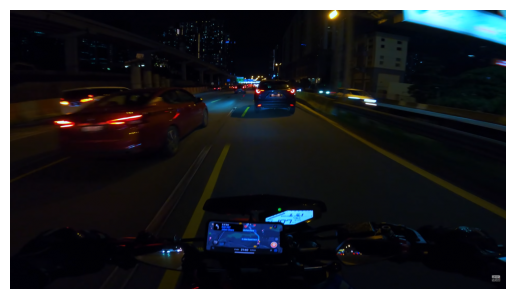

In [34]:
# Image id를 input으로 annotations의 image dict를 return하는 함수
# image id는 1~200

# random하게 데이터 시각화해보기
img = coco.loadImgs(np.random.randint(1,201))[0]
I = io.imread('{}/images/{}'.format(dataDir,img['file_name']))/255.0
plt.axis('off')
plt.imshow(I)
plt.show()

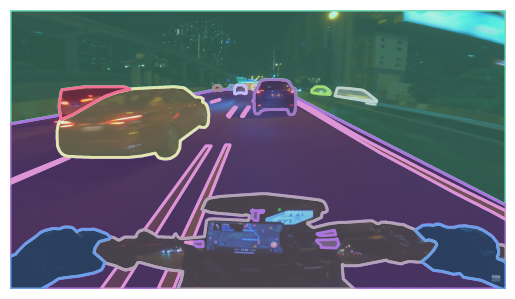

In [35]:
#해당 타겟 segmentation 시각화
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIDs, iscrowd=None)
# Annotation id를 input으로 annotation dict 전체를 return하는 함수
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

ㄴ> 6개의 카테고리별로 잘 나뉘어져 있지만 같은 자동차에 대해 다른 카테고리로 라벨링이 되어있다. movable

In [39]:
for i in range(len(anns)):
  className = getClassName(anns[i]['category_id'], cats)
  print(className)

Undrivable
Road
Lane Mark
Moveable
Moveable
Moveable
Moveable
Moveable
Moveable
Moveable
Moveable
Moveable
Moveable
Moveable
My bike
Rider


Unique pixel values in the mask are: [0. 1. 2. 3. 4. 5. 6.]


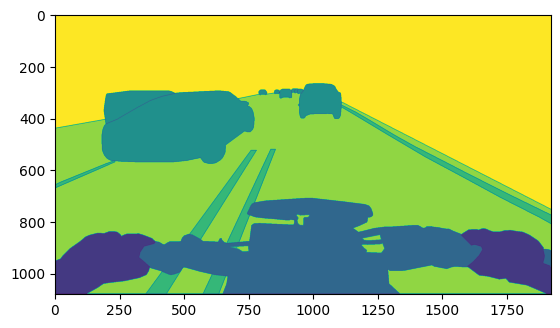

In [44]:
#seg mask 만들기


Classes = ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = Classes.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)

plt.imshow(mask)
print('Unique pixel values in the mask are:', np.unique(mask))

In [52]:
imgs = []
for i in range(1,201):
  imgs.append(coco.loadImgs(i)[0])

len(imgs)

200

#지금까지 과정 함수화 하여 사용하자 -> datagenerator 구현

In [129]:
#annfile dir받아 coco class 만들고 이미지 annotation 분할하기
def filterDataset(folder, classes=None):
    annFile = '{}/COCO_motorcycle.json'.format(folder)
    coco = COCO(annFile)

    images = []
    if classes!=None:
        for className in classes:
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)

    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)

    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])

    random.shuffle(unique_images)
    dataset_size = len(unique_images)

    return unique_images, dataset_size, coco

# 위의 코드블럭 copy
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None


# 이미지 받아 기본적인 전처리 수행
def getImage(imageObj, datadir, input_image_size):
    # Read and normalize
    # 참고
    #img = coco.loadImgs(np.random.randint(1,201))[0]
    #I = io.imread('{}/images/{}'.format(dataDir,img['file_name']))/255.0
    train_img = io.imread(datadir + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If RGB 3 channel image
        return train_img
    else: # 흑백 img to 3 channels
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img


def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)
        #train_mask = np.maximum(coco.annToMask(anns[a])*pixel_value, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGenerator(images, classes, coco, folder, input_image_size=(1920, 1080), batch_size=4):
    img_folder = '{}/images/'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds()
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size
            imageObj = images[i]
            #Retrieve Image
            train_img = getImage(imageObj, img_folder, input_image_size)
            # Create Mask
            train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)

            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask

        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)

        yield img, mask

In [130]:
folder = '/content/drive/MyDrive/MotorcycleNight_dataset'
classes = ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']

images, dataset_size, coco = filterDataset(folder, classes)

loading annotations into memory...
Done (t=2.17s)
creating index...
index created!


In [131]:
batch_size = 4
input_image_size = (1920, 1080)

train_gen = dataGenerator(images, classes, coco, folder,input_image_size, batch_size)

In [156]:
'''
import numpy as np
steps = 2
imgs, labels = [], []

for a, b in train_gen:
    imgs.extend(a)
    labels.extend(b)

imgs = np.asarray(imgs)
labels = np.asarray(labels)
'''

array([], dtype=float64)

In [132]:
#generator visualize

def visualizeGenerator(gen):
    img, mask = next(gen)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])

            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

In [ ]:
# 이 부분이 error나는데 디버깅을 못하겠다..
visualizeGenerator(train_gen)

In [134]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)

    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)

    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img,
                             batch_size = img.shape[0],
                             seed = seed,
                             shuffle=True)
        g_y = mask_gen.flow(mask,
                             batch_size = mask.shape[0],
                             seed = seed,
                             shuffle=True)

        img_aug = next(g_x)/255.0

        mask_aug = next(g_y)


        yield img_aug, mask_aug

In [135]:
augGeneratorArgs = dict(featurewise_center = False,
                        samplewise_center = False,
                        rotation_range = 5,
                        width_shift_range = 0.01,
                        height_shift_range = 0.01,
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],
                        horizontal_flip = True,
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(train_gen, augGeneratorArgs)

In [152]:
train_gen



<generator object dataGenerator at 0x787783e5d380>

In [148]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [139]:
input_size = (1920, 1080, 3)  # 입력 이미지의 크기 (예: 256x256 픽셀, 3 채널)
num_classes = 6  # 세그멘테이션 결과로 출력되는 클래스 수

model = unet(input_size, num_classes)

ValueError: ignored

In [146]:
# Set your parameters
n_epochs = 100
steps_per_epoch = 50

model = unet(input_size, num_classes)
opt = Adam(learning_rate=1e-4)
lossFn = SparseCategoricalCrossentropy()

# Compile your model first
model.compile(loss = lossFn, optimizer = opt, metrics=['accuracy'])

# Start the training process
history = model.fit(x = aug_gen,
                steps_per_epoch = steps_per_epoch,
                epochs = n_epochs,
                verbose = True)

TypeError: ignored